# Evaluate fitting on experimental data

To evaluate PyChemelt's performance on an experimental dataset the ACBP dataset from *Hamborg et al.*<sup>1</sup> was processed and used. This datasets provides 16 thermal denaturation curves with differing concentrations of GuHCL. This dataset was thus used to fit the parameters in a 2 dimensional fashion to the curves regarding temperature and chemical denaturation. <br>


<sup>1</sup> *Hamborg, Louise, et al. "Global analysis of protein stability by temperature and chemical denaturation." Analytical Biochemistry 605 (2020): 113863.*

In [2]:
from pychemelt import Sample

import numpy as np
import pandas as pd

from plotly.subplots import make_subplots
from pychemelt.utils.processing import (
    get_colors_from_numeric_values,
    combine_sequences
)

from pychemelt.utils.plotting import *
import plotly.graph_objs as go

from scripts import display_figure_static

In [3]:

# creating a Sample object for the storgae and processing of the DSF data
sample = Sample()

# reading the data
sample.read_file('../data/20191202_ACBP_15C_95C_processed.xlsx')

sample.set_denaturant_concentrations()

# Selecting conditions
sample.set_signal(['330nm', '350nm'])

#using all curves except the curve without denaturant as in the paper
sample.select_conditions([True]*15 + [False])


#Plotting the selected signals against the temperature
plot_unfolding(sample)

In [4]:
# Reducing the amount of data and preprocessing steps for a faster analysis
sample.pre_fit = False
sample.max_points = 200


sample.expand_multiple_signal()

# For the estimates of the baselines, linear was used for the folded protein and exponential for the unfolded.
# the exponential baseline for the unfolded was preferred over quadratic as it previously was shown to generalize 
# better and ran faster in during testing.
sample.estimate_baseline_parameters(
    native_baseline_type='linear',
    unfolded_baseline_type='exponential',
)

# estimations of parameters
sample.estimate_derivative()
sample.guess_Tm()

# All local fit for parameter estimation
sample.fit_thermal_unfolding_local()

# Setting the number of residues of the protein for an initial estiamte of the Cp value
sample.n_residues = 86 # doi: 10.1042/bj2450857
sample.guess_Cp()


sample.set_signal_id()


In [5]:
fitting_results = {
    "Tm (°C)":[],
    "ΔH (kcal/mol)":[],
    "Cp (kcal/mol/°C)":[],
    "m-value (kcal/mol/M)":[],
    "ΔG-H2O (kcal/mol)":[],
}


# fit with global thermodynamic parameters, local slopes and local baselines
sample.fit_thermal_unfolding_global()


# Save the fitted thermodynamic parameters

Tm = sample.params_df.iloc[0,1]
dH = sample.params_df.iloc[1,1]
Cp = sample.params_df.iloc[2,1]
m = sample.params_df.iloc[3,1]
dG = sample.dg_df.iloc[50,0]

fitting_results["Tm (°C)"].append(Tm)
fitting_results["ΔH (kcal/mol)"].append(dH)
fitting_results["Cp (kcal/mol/°C)"].append(Cp)
fitting_results["m-value (kcal/mol/M)"].append(m)
fitting_results["ΔG-H2O (kcal/mol)"].append(dG)


plot_unfolding(sample)


In [6]:

# fit with global thermodynamic parameters and slope, local baselines

sample.fit_thermal_unfolding_global_global()

# Save the fitted thermodynamic parameters

Tm = sample.params_df.iloc[0,1]
dH = sample.params_df.iloc[1,1]
Cp = sample.params_df.iloc[2,1]
m = sample.params_df.iloc[3,1]
dG = sample.dg_df.iloc[50,0]

fitting_results["Tm (°C)"].append(Tm)
fitting_results["ΔH (kcal/mol)"].append(dH)
fitting_results["Cp (kcal/mol/°C)"].append(Cp)
fitting_results["m-value (kcal/mol/M)"].append(m)
fitting_results["ΔG-H2O (kcal/mol)"].append(dG)

plot_unfolding(sample)

In [7]:
# fit with global thermodynamic parameters, slopes and baselines

sample.fit_thermal_unfolding_global_global_global()

# Save the fitted thermodynamic parameters

Tm = sample.params_df.iloc[0,1]
dH = sample.params_df.iloc[1,1]
Cp = sample.params_df.iloc[2,1]
m = sample.params_df.iloc[3,1]
dG = sample.dg_df.iloc[50,0]

fitting_results["Tm (°C)"].append(Tm)
fitting_results["ΔH (kcal/mol)"].append(dH)
fitting_results["Cp (kcal/mol/°C)"].append(Cp)
fitting_results["m-value (kcal/mol/M)"].append(m)
fitting_results["ΔG-H2O (kcal/mol)"].append(dG)


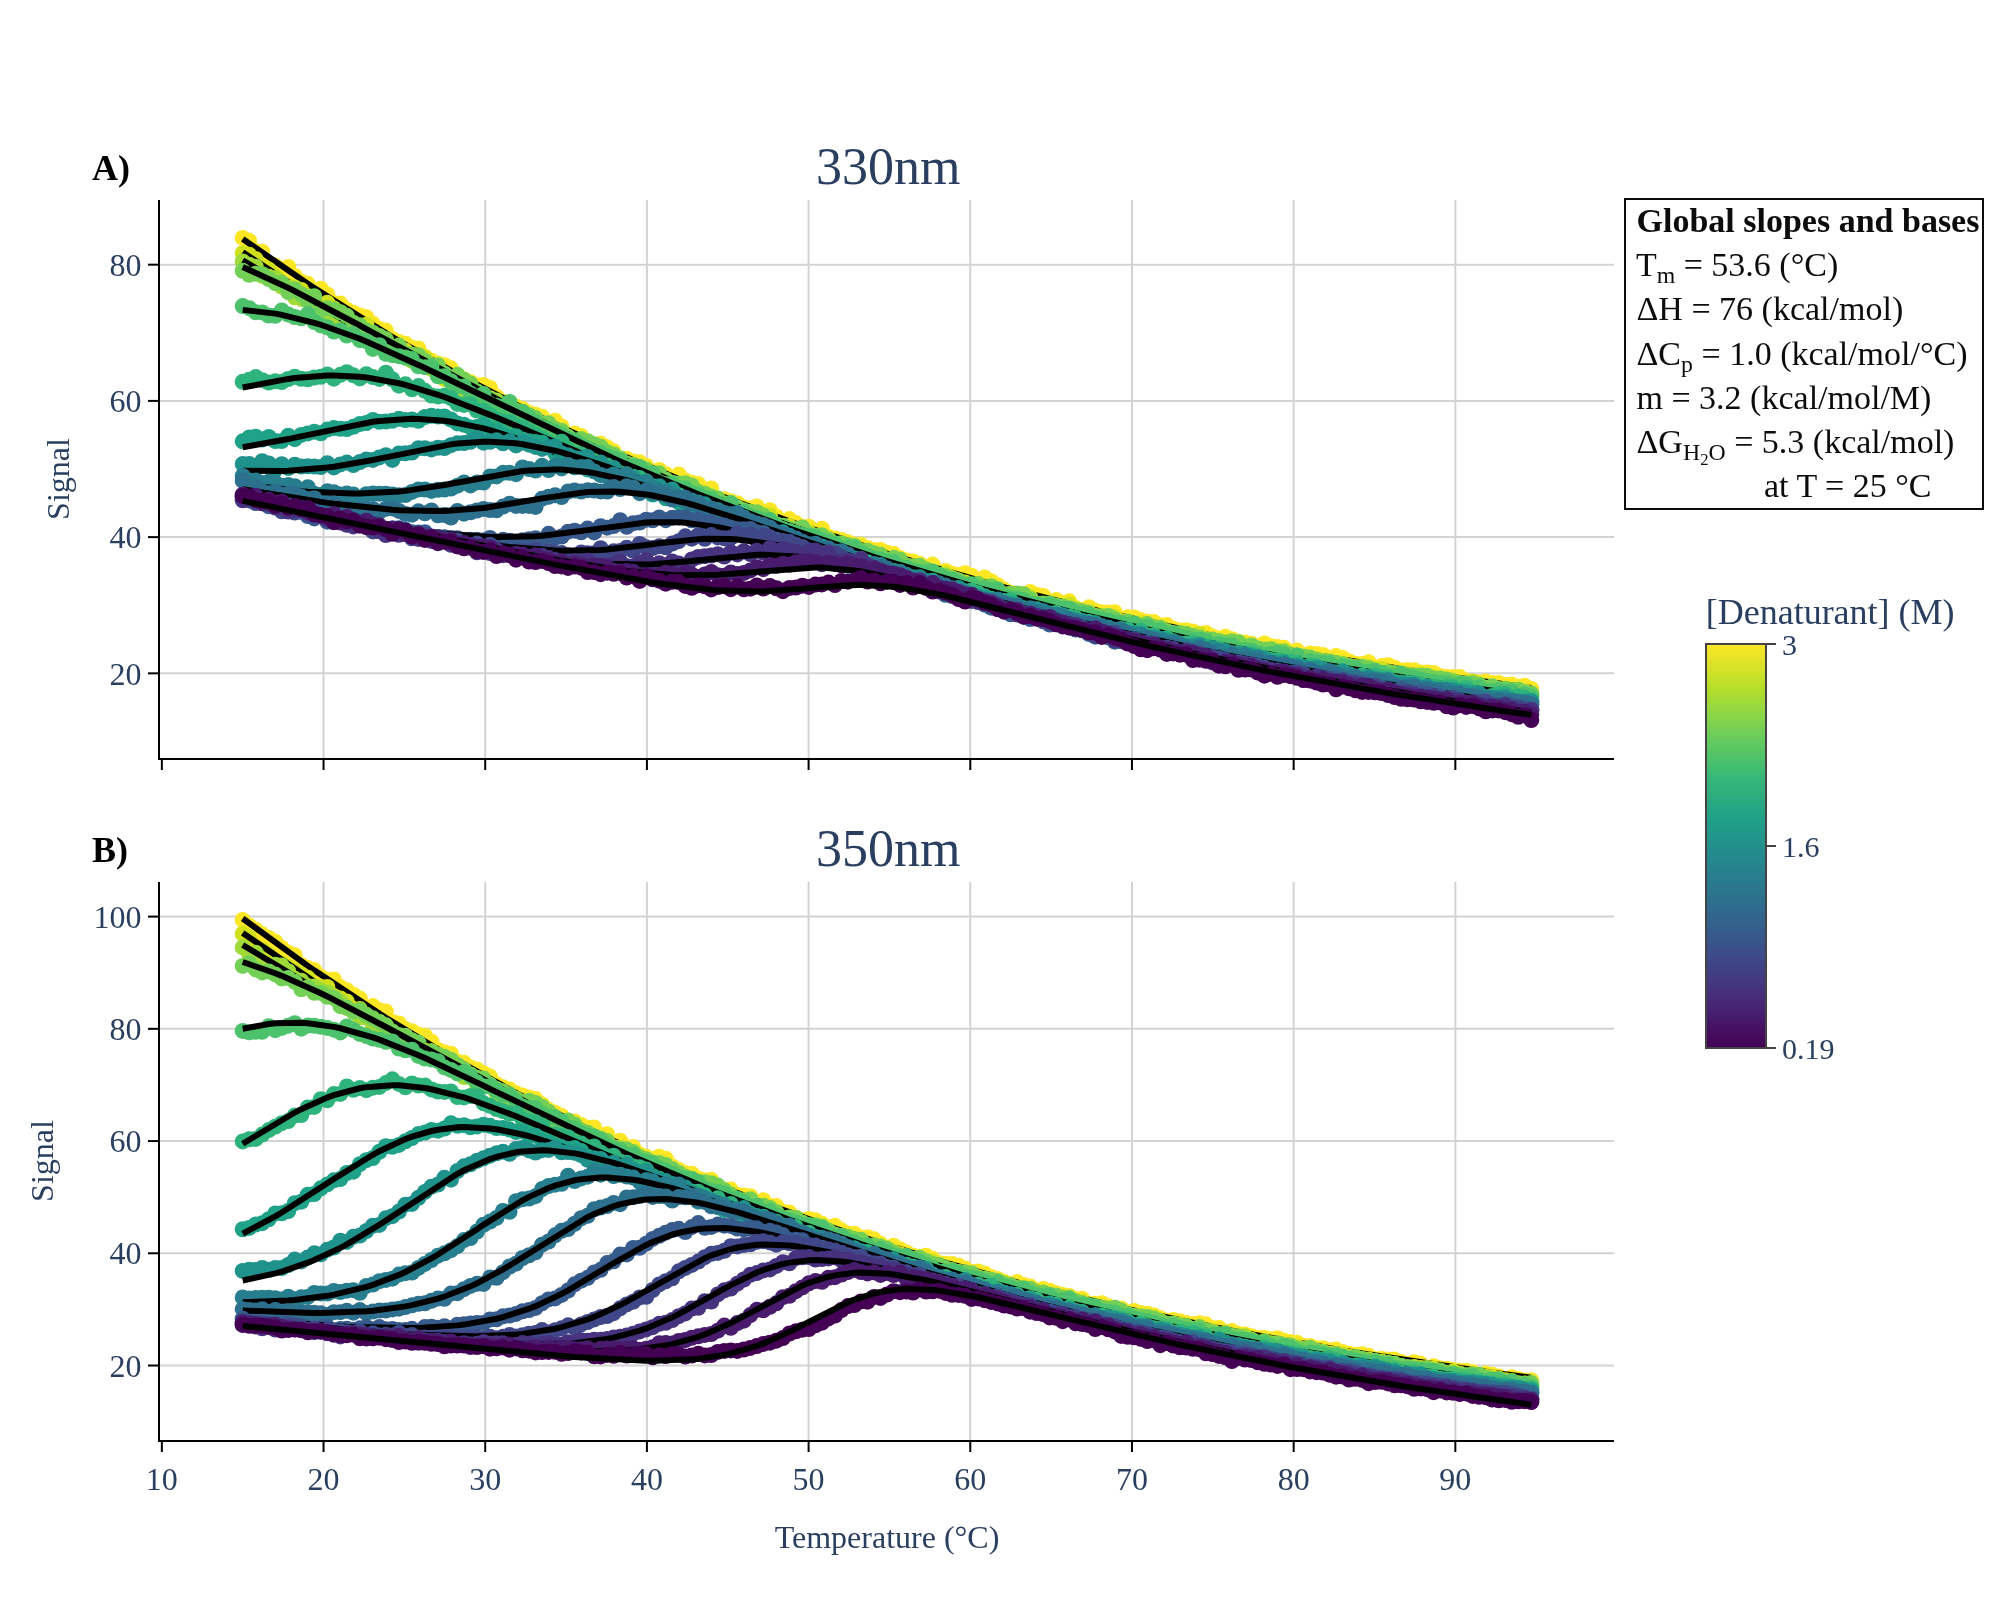

In [ ]:
# modifying the plot_unfolding method for the generation of the figure

# Set defaults for configuration objects
plot_config = PlotConfig()
axis_config = AxisConfig()
layout_config = LayoutConfig()
legend_config = LegendConfig()

# Extract the minimum and maximum denaturation concentration
concs = sample.denaturant_concentrations

min_conc = np.min(concs)
max_conc = np.max(concs)

colors = get_colors_from_numeric_values(concs, min_conc, max_conc)

n_subplots = sample.nr_signals

# Set number of rows: 2 if less than 8 plots, else 3
nrows = 2 if n_subplots < 9 else 3
nrows = min(nrows, n_subplots)  # Do not exceed the number of plots - case n equal 1

ncols = int(np.ceil(n_subplots / nrows))

row_arr = np.arange(1, nrows + 1)
col_arr = np.arange(1, ncols + 1)
# Row and column counters for subplotting
row_col_info = combine_sequences(row_arr, col_arr)

subplot_titles = sample.signal_names

fig = make_subplots(
    rows=nrows,
    cols=ncols,
    shared_xaxes=True,
    shared_yaxes=False,
    vertical_spacing=layout_config.vertical_spacing,
    subplot_titles=subplot_titles)

subplot_idx = 0

fittings_done = sample.global_fit_params is not None

ys_fit = None

nr_den = sample.nr_den

for i in range(n_subplots):

    row = row_col_info[subplot_idx][0]
    col = row_col_info[subplot_idx][1]



    ys_fit = sample.predicted_lst_multiple[i]
    xs     = sample.temp_lst_expanded[i*nr_den:(i+1)*nr_den]
    ys     = sample.signal_lst_expanded[i*nr_den:(i+1)*nr_den]


    for j,conc in enumerate(concs):

        color = colors[j]

        x = xs[j]
        y = ys[j]

        fig.add_trace(
            go.Scatter(
                x=x, y=y, mode='markers',
                marker=dict(size=plot_config.marker_size, color=color),
                name=f'{conc:.2f} M',
                showlegend=False
            ),
            row=row, col=col
        )



        # count np.nans in ys_fit
        ys_fit_j = ys_fit[j]

        fig.add_trace(
            go.Scatter(
                x=x, y=ys_fit_j, mode='lines',
                line=dict(color='black', width=plot_config.line_width),
                showlegend=False,
                hoverinfo='skip',
                hovertemplate=None
            ),
            row=row, col=col
        )

    subplot_idx += 1

    # Add an annotation inside the subplot showing the subfigure numeration
    axis_index = i + 1
    # Plotly expects 'x domain'/'y domain' (no '1') for the first axis; for others use 'xN domain'
    if axis_index == 1:
        xref = 'x domain'
        yref = 'y domain'
    else:
        xref = f'x{axis_index} domain'
        yref = f'y{axis_index} domain'

    # Add panel label (A, B, C, etc.)
    panel_label = chr(65 + i)  # 65 is ASCII code for 'A'
    fig.add_annotation(
        x=-0.05,
        y=1.1,
        xref=xref,
        yref=yref,
        text=f'<b>{panel_label})</b>',
        showarrow=False,
        align='left',
        font=dict(size=18, color='black')
    )

# Update subplot layout with white background and axis styling
fig.update_layout(
    font_family="Roboto",
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend=dict(font=dict(size=plot_config.font_size - 1))
)

for i in range(n_subplots):

    row = row_col_info[i][0]
    col = row_col_info[i][1]

    # Set the x-axis title only for the last row
    title_text_x = 'Temperature (°C)' if row == nrows else ''

    # Set the y-axis title only for the first column
    title_text_y = 'Signal' if col == 1 else ''

    fig.update_xaxes(
        title_text=title_text_x,
        showgrid=axis_config.showgrid_x,
        gridwidth=axis_config.gridwidth,
        gridcolor='lightgray',
        showline=True,
        linewidth=axis_config.linewidth,
        linecolor='black',
        zeroline=False,
        tickcolor='black',
        ticks="outside",
        tickwidth=axis_config.tickwidth,
        ticklen=axis_config.ticklen,
        title_font_size=plot_config.font_size,
        tickfont_size=plot_config.font_size,
        col = col,
        row = row
    )

    fig.update_yaxes(
        title_text=title_text_y,
        showgrid=axis_config.showgrid_y,
        gridwidth=axis_config.gridwidth,
        gridcolor='lightgray',
        showline=True,
        linewidth=axis_config.linewidth,
        linecolor='black',
        zeroline=False,
        tickcolor='black',
        ticks="outside",
        tickwidth=axis_config.tickwidth,
        ticklen=axis_config.ticklen,
        title_font_size=plot_config.font_size,
        tickfont_size=plot_config.font_size,
        nticks = axis_config.n_y_axis_ticks,
        col=col,
        row=row
    )

# Build colorbar dict using legend_config values (orientation and x/y position)
# Choose sensible anchors depending on orientation
_xanchor = 'center' if legend_config.color_bar_orientation == 'h' else 'left'
_yanchor = 'top'    if legend_config.color_bar_orientation == 'h' else 'middle'

colorbar_dict = dict(
    title='[Denaturant] (M)',
    tickvals=[min_conc, 0.5*(min_conc + max_conc), max_conc],
    ticktext=[f"{min_conc:.2g}", f"{(min_conc + max_conc) * 0.5:.2g}", f"{max_conc:.2g}"],
    len=legend_config.color_bar_length,
    outlinewidth=1,
    ticks='outside',
    tickfont=dict(size=plot_config.font_size - 1),
    orientation=legend_config.color_bar_orientation,
    x=legend_config.color_bar_x_pos,
    y=legend_config.color_bar_y_pos,
    xanchor=_xanchor,
    yanchor=_yanchor
)


fig.add_trace(
    go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(
            colorscale='Viridis',
            cmin=min_conc,
            cmax=max_conc,
            colorbar=colorbar_dict
        ),
        showlegend=False,
        hoverinfo='skip'
    ),
    row=1, col=1
)


# Adding the thermodynamic parameters of the fitted formula 
fig.add_annotation(
    x=legend_config.color_bar_x_pos + 0.08,
    y=legend_config.color_bar_y_pos + 0.25,  # move ABOVE colorbar
    xref="paper",
    yref="paper",
    xanchor="center",
    yanchor="bottom",
    showarrow=False,
    align="left",
    text=(
        " <b>Global slopes and bases</b><br>"
        f" T<sub>m</sub> = {Tm:.1f} (°C) <br>"
        f" ΔH = {dH:.1f} (kcal/mol) <br>"
        f" ΔC<sub>p</sub> = {Cp:.1f} (kcal/mol/°C) <br>"
        f" m = {m:.1f} (kcal/mol/M) <br>"
        f" ΔG<sub>H<sub>2</sub>O</sub> = {dG:.1f} (kcal/mol) <br> "
        f"               at T = 25 °C"
    ),
    font=dict(
        size=plot_config.font_size + 1,
        color="black"
    ),
    bgcolor="white",
    bordercolor="black",
    borderwidth=1,
    opacity=0.95
)


#changing the subplot title sizes

def is_subplot_title(x):
    return x.text in ["330nm", "350nm"]

fig.update_annotations(
    selector=is_subplot_title,
    patch=dict(font=dict(size=plot_config.font_size + 10))
)

fig = config_fig(
    fig,
    plot_config.width,
    plot_config.height,
    plot_config.type
)

fig.write_image("5_evaluate_fittings_on_ACBP_data.png", scale=2)
display_figure_static(fig,height=800, width=1000)

In [9]:
# thermodynamic parameters of the fitted function on the data

pd.DataFrame(fitting_results, index=["global", "global global", "global global global"])

,Tm (°C),ΔH (kcal/mol),Cp (kcal/mol/°C),m-value (kcal/mol/M),ΔG-H2O (kcal/mol)
global,54.510305,73.551393,0.641958,3.312565,5.744380
global global,53.126833,79.237105,1.072680,3.251804,5.491145
global global global,53.611116,75.956513,1.032051,3.195168,5.318519


In [10]:
# Trying to use either 330 nm or 350 nm only

signal_lst = [['330nm'], ['350nm']]



for signal in signal_lst:

    sample = Sample()

    # reading the data
    sample.read_file('../data/20191202_ACBP_15C_95C_processed.xlsx')

    # Selecting conditions and data
    sample.set_denaturant_concentrations()
    sample.set_signal(signal)
    sample.select_conditions([True]*15 + [False])


    sample.pre_fit = False
    sample.max_points = 200

    sample.expand_multiple_signal()
    sample.estimate_baseline_parameters(
    native_baseline_type='linear',
    unfolded_baseline_type='exponential',
    )

    # when using the quadratic unfolded baseline estimator no fitting was achieved, even when only considering
    # 200 datapoints and after 50 min on a regular laptop

    # estimations of parameters
    sample.estimate_derivative()
    sample.guess_Tm()


    # Setting the number of residues of the protein for an initial estiamte of the Cp value
    sample.n_residues = 86 # doi: 10.1042/bj2450857
    sample.guess_Cp()


    # All local fit
    sample.fit_thermal_unfolding_local()

    sample.set_signal_id()

    fitting_results = {
    "Tm (°C)":[],
    "ΔH (kcal/mol)":[],
    "Cp (kcal/mol/°C)":[],
    "m-value (kcal/mol/M)":[],
    "ΔG-H2O (kcal/mol)":[],
    }   

    fittings_lst = [sample.fit_thermal_unfolding_global, sample.fit_thermal_unfolding_global_global, sample.fit_thermal_unfolding_global_global_global]

    for fitting in fittings_lst:
        
        fitting()

        Tm = sample.params_df.iloc[0,1]
        dH = sample.params_df.iloc[1,1]
        Cp = sample.params_df.iloc[2,1]
        m = sample.params_df.iloc[3,1]
        dG = sample.dg_df.iloc[50,0]

        fitting_results["Tm (°C)"].append(Tm)
        fitting_results["ΔH (kcal/mol)"].append(dH)
        fitting_results["Cp (kcal/mol/°C)"].append(Cp)
        fitting_results["m-value (kcal/mol/M)"].append(m)
        fitting_results["ΔG-H2O (kcal/mol)"].append(dG)

    df = pd.DataFrame(fitting_results, index=["global", "global global", "global global global"])

    print("Used signal: ", signal[0])

    print(df)

    plot_unfolding(sample)

Used signal:  330nm
                        Tm (°C)  ΔH (kcal/mol)  Cp (kcal/mol/°C)  \
global                54.049534      72.170532          0.574116   
global global         51.599214      91.567577          1.594771   
global global global  52.335368      82.284419          1.320082   

                      m-value (kcal/mol/M)  ΔG-H2O (kcal/mol)  
global                            3.259230           5.644183  
global global                     3.408796           5.713314  
global global global              3.206065           5.350962  
Used signal:  350nm
                        Tm (°C)  ΔH (kcal/mol)  Cp (kcal/mol/°C)  \
global                54.614931      73.937652          0.662656   
global global         53.419825      77.219904          0.994979   
global global global  53.724740      75.760961          1.008321   

                      m-value (kcal/mol/M)  ΔG-H2O (kcal/mol)  
global                            3.325966           5.766019  
global global                 

When looking at the results of using both wavelengths, 330 nm and 350 nm in together, the three fitting methods, fitting slopes and baselines locally, fitting slopes globally and baselines locally, and fitting slopes and baselines globally, agree roughly on the melting temperature T<sub>m</sub> and the m-value as well as the Gibbs free energy ΔG<sub>H<sub>2</sub>O</sub> at the reference temperature of T = 25 °C. 
The three methods differ, however, in the free enthalpy ΔH and heat constant ΔC<sub>p</sub>. The fit with the global local slopes and baselines has the lowest free enthalpy and ΔC<sub>p</sub>. the other two methods agree on the ΔC<sub>p</sub> but have differing free enthalpy, where the fitting method with the global thermodynamic parameters and slopes has the highest enthalpy. 

Regarding the melting temperatue T<sub>m</sub> all fitting methods achieve results approximating the results in the paper of *Hamborg et al.*<sup>1</sup> and get close for the m-value and ΔG<sub>H<sub>2</sub>O</sub> <b>(T<sub>m</sub>: 53.05 ± 0.1 °C, ΔH: 82.46 ± 3.59 kcal/mol, ΔC<sub>p</sub>: 1.1 ± 0.14 kcal/mol/°C, m-value: 3.54 ± 0.07 kcal/mol/M, ΔG<sub>H<sub>2</sub>O</sub>: 5.76 ± 0.14 kcal/mol)</b>. There were some notable differences when considering ΔC<sub>p</sub> and ΔH of all methods with the results presented by the paper. However, a standard baseline for these values is not known. The m-value was also not far off the previously shown value of 3.51 ± 0.02 kcal/mol/M <sup>2</sup>.

The fitting method used by *Hamborg et al.*<sup>1</sup> used global slopes and baselines were. Here it was shown that the parameters agreed to some extend with their results, especially T<sub>m</sub> was stable. Differences could arise due to the normalisation that was performed in this paper, while here a scaling was performed.

When only using the 330 nm wavelength fluorescence signal, the melting temperatur T<sub>m</sub> and is more instable then the combined signal fit or just using 350 nm. In general do the results of the 350 nm signal closely resemble the results of the combined fitting, suggesting a greater influence and stability of the 350 nm signal.


<sup>2</sup> Teilum, Kaare, Birthe B. Kragelund, and Flemming M. Poulsen. "Transient structure formation in unfolded acyl-coenzyme A-binding protein observed by site-directed spin labelling." Journal of molecular biology 324.2 (2002): 349-357.
